In [1]:
import os, math, cv2, sys, glob, random, argparse
from multiprocessing import Pool
from itertools import product
import numpy as np
import rasterio

%matplotlib inline
import matplotlib.pyplot as plt


sys.path.append('../utils')
sys.path.append('../models')
from dataloaders import *
from unet_blocks import *

In [2]:
def read_band(band):
    return rasterio.open(band).read()[0]

def read_bands(band_paths):
    pool = Pool(26)
    bands = pool.map(read_band, band_paths)
    pool.close()
    return bands

def _match_band(two_date):
    return match_band(two_date[1], two_date[0])

def match_bands(date1, date2):
    pool = Pool(13)
    date2 = pool.map(_match_band, [[date1[i], date2[i]] for i in range(len(date1))])
    pool.close()
    return date2

def _resize(band):
    return cv2.resize(band, (10980, 10980))

def stack_bands(bands):
    pool = Pool(26)
    bands = pool.map(stretch_8bit, bands)
    pool.close()

    return cv2.merge(bands).astype(np.uint8)

In [2]:
data_path = '../../../Yiwu/cd_out/'
tiles = os.listdir(data_path)

In [3]:
for tile in tiles:
    if 'T51RTM' in tile:
        print (tile)

T51RTM_20170228T023631_20181001T023551.tif
T51RTM_20170228T023631_20171225T024121.tif
T51RTM_20151126T024032_20171225T024121.tif
T51RTM_20171225T024121_20181001T023551.tif
T51RTM_20151126T024032_20170228T023631.tif
T51RTM_20151126T024032_20181001T023551.tif


In [4]:
a_b = rasterio.open(data_path + 'T51RTM_20151126T024032_20170228T023631.tif').read()[0]
b_c = rasterio.open(data_path + 'T51RTM_20170228T023631_20171225T024121.tif').read()[0]
a_c = rasterio.open(data_path + 'T51RTM_20151126T024032_20171225T024121.tif').read()[0]

In [9]:
a = cv2.imread('../../../Yiwu/emp_ana/T51RTM_20151126T024032.png')
b = cv2.imread('../../../Yiwu/emp_ana/T51RTM_20170228T023631.png')
c = cv2.imread('../../../Yiwu/emp_ana/T51RTM_20171225T024121.png')

In [5]:
a_c_sum = a_b + b_c  
a_c_sum[a_c_sum > 0] = 1

a_c_and = np.logical_and(a_c_sum,a_c)

ab_or_bc = np.logical_or(a_b,b_c)
ac_and_ab_or_bc = np.logical_and(ab_or_bc, a_c)

In [18]:
sx, ex = 200, 400
sy, ey = 200, 400

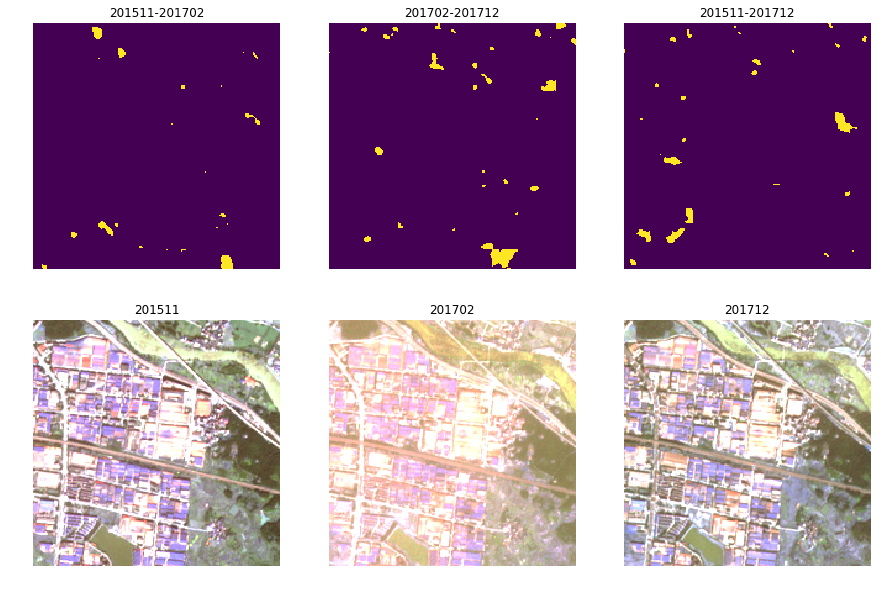

In [19]:
f = plt.figure(figsize=(15,10))


f.add_subplot(2,3,1)
plt.imshow(a_b[sx:ex,sy:ey])
plt.axis('off')
plt.title('201511-201702')

f.add_subplot(2,3,2)
plt.imshow(b_c[sx:ex,sy:ey])
plt.axis('off')
plt.title('201702-201712')

f.add_subplot(2,3,3)
plt.imshow(a_c[sx:ex,sy:ey])
plt.axis('off')
plt.title('201511-201712')


f.add_subplot(2,3,4)
plt.imshow(a[sx:ex,sy:ey])
plt.axis('off')
plt.title('201511')

f.add_subplot(2,3,5)
plt.imshow(b[sx:ex,sy:ey])
plt.axis('off')
plt.title('201702')

f.add_subplot(2,3,6)
plt.imshow(c[sx:ex,sy:ey])
plt.axis('off')
plt.title('201712')

plt.savefig('../../../Yiwu/emp_ana/51RTM_' + str(sx) + '_' + str(ex) + '_' + str(sy) + '_' + str(ey) + '.pdf', dpi=1000, format='pdf')

In [26]:
for w in [1,2,3]:#[4,6,8,10,12,14,16,18,20]:
    change_in_both = 0
    change_in_either = 0
    for i in range(0,10980,w):
        for j in range(0,10980,w):
            if np.sum(ab_or_bc[i:i+w,j:j+w]) > 0 and np.sum(a_c[i:i+w,j:j+w]) > 0:
                change_in_both += 1
            if np.sum(ab_or_bc[i:i+w,j:j+w]) == 0 and np.sum(a_c[i:i+w,j:j+w]) > 0:
                change_in_either += 1
            if np.sum(ab_or_bc[i:i+w,j:j+w]) > 0 and np.sum(a_c[i:i+w,j:j+w]) == 0:
                change_in_either += 1

    print (w, change_in_both / change_in_either)

1 0.1091714549997306
2 0.11714017510238593
3 0.12903371349063578


In [ ]:
#w    percentage matches
#1 0.1091
#2 0.1171
#3 0.1290
#4, 0.135
#6, 0.159
#8, 0.172
#10, 0.204
#12, 0.226
#14, 0.256
#16, 0.262
#18, 0.313
#20, 0.345

In [12]:
d1_path = glob.glob('../../../Yiwu/SAFES/*20151126T024032*T51RTM*/GRANULE/**/IMG_DATA/*_B*.jp2')[0][:-7]
d2_path = glob.glob('../../../Yiwu/SAFES/*20170228T023631*T51RTM*/GRANULE/**/IMG_DATA/*_B*.jp2')[0][:-7]
d3_path = glob.glob('../../../Yiwu/SAFES/*20171225T024121*T51RTM*/GRANULE/**/IMG_DATA/*_B*.jp2')[0][:-7]
d4_path = glob.glob('../../../Yiwu/SAFES/*20181001T023551*T51RTM*/GRANULE/**/IMG_DATA/*_B*.jp2')[0][:-7]

In [14]:
d1_bands = [d1_path + 'B02.jp2', d1_path + 'B03.jp2', d1_path + 'B04.jp2']
d2_bands = [d2_path + 'B02.jp2', d2_path + 'B03.jp2', d2_path + 'B04.jp2']
d3_bands = [d3_path + 'B02.jp2', d3_path + 'B03.jp2', d3_path + 'B04.jp2']
d4_bands = [d4_path + 'B02.jp2', d4_path + 'B03.jp2', d4_path + 'B04.jp2']


In [ ]:
# #load bands for two dates and do preprocessing
# d1d2 = read_bands(d1_bands + d2_bands)
# d1d2[13:] = match_bands(d1d2[:13], d1d2[13:])
# d1, d2 = stack_bands(d1d2)

In [17]:
d1d2d3d4 = read_bands(d1_bands + d2_bands + d3_bands + d4_bands)

In [18]:
d1d2d3d4[3:6] = match_bands(d1d2d3d4[:3], d1d2d3d4[3:6])
d1d2d3d4[6:9] = match_bands(d1d2d3d4[:3], d1d2d3d4[6:9])
d1d2d3d4[9:] = match_bands(d1d2d3d4[:3], d1d2d3d4[9:])

In [23]:
d1 = d1d2d3d4[:3]
d2 = d1d2d3d4[3:6]
d3 = d1d2d3d4[6:9]
d4 = d1d2d3d4[9:]
del d1d2d3d4

In [26]:
d1 = stack_bands(d1)

In [27]:
d2 = stack_bands(d2)
d3 = stack_bands(d3)
d4 = stack_bands(d4)

In [31]:
cv2.imwrite('../../../Yiwu/emp_ana/T51RTM_20151126T024032.png',d1.astype(np.uint8))
cv2.imwrite('../../../Yiwu/emp_ana/T51RTM_20170228T023631.png',d2.astype(np.uint8))
cv2.imwrite('../../../Yiwu/emp_ana/T51RTM_20171225T024121.png',d3.astype(np.uint8))
cv2.imwrite('../../../Yiwu/emp_ana/T51RTM_20181001T023551.png',d4.astype(np.uint8))


cv2.imwrite('../../../Yiwu/emp_ana/T51RTM_20151126T024032_20170228T023631.png',d1.astype(np.uint8))
cv2.imwrite('../../../Yiwu/emp_ana/T51RTM_20170228T023631_20171225T024121.png',d2.astype(np.uint8))
cv2.imwrite('../../../Yiwu/emp_ana/T51RTM_20171225T024121_20181001T023551.png',d3.astype(np.uint8))
cv2.imwrite('../../../Yiwu/emp_ana/T51RTM_20151126T024032_20181001T023551.png',d4.astype(np.uint8))

True

In [6]:
b2 = rasterio.open('../../../Yiwu/SAFES/S2A_MSIL1C_20151126T024032_N0204_R089_T51RTN_20170228T133751.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_EPA__20170228T092218_A002231_T51RTN_N02.04/IMG_DATA/S2A_OPER_MSI_L1C_TL_EPA__20170228T092218_A002231_T51RTN_B02.jp2').read()[0]
b3 = rasterio.open('../../../Yiwu/SAFES/S2A_MSIL1C_20151126T024032_N0204_R089_T51RTN_20170228T133751.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_EPA__20170228T092218_A002231_T51RTN_N02.04/IMG_DATA/S2A_OPER_MSI_L1C_TL_EPA__20170228T092218_A002231_T51RTN_B03.jp2').read()[0]
b4 = rasterio.open('../../../Yiwu/SAFES/S2A_MSIL1C_20151126T024032_N0204_R089_T51RTN_20170228T133751.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_EPA__20170228T092218_A002231_T51RTN_N02.04/IMG_DATA/S2A_OPER_MSI_L1C_TL_EPA__20170228T092218_A002231_T51RTN_B04.jp2').read()[0]

b2 = stretch_8bit(b2)
b3 = stretch_8bit(b3)
b4 = stretch_8bit(b4)

rgb = cv2.merge([b2,b3,b4])
cv2.imwrite('../../../Yiwu/emp_ana/T51RTN_20151126T024032.png', rgb)

True